In [1]:
using LinearAlgebra, DifferentialEquations

import PyPlot
Plt = PyPlot;

# Actin Constants

In [34]:
"`ka′`, the base annealing rate per micromolar per second."
ka′ = 300

"`L′`, the length of 'short' polymers"
L′ = 30


"`k₋₁`, the subtraction rate from dimers per second."
k₋₁ = 1e0

"`k₋₂`, the subtraction rate from trimers per second."
k₋₂ = 1e0

"`k₋₃`, the subtraction rate from tetramers per second."
k₋₃ = 1e0

"`k₋′`, the subtraction rate from polymers per second."
k₋′ = 1e0


"`kf1`, the bond fragmentation rate per second."
kf1 = 1.1e-4

"`kf2`, the second-order fragmentation rate per micromolar per second."
kf2 = 1.8e-8


"`kz₊`, the capping rate per micromolar [CapZ] per second."
kz₊ = 3.5

"`kz₋`, the uncapping rate per second."
kz₋ = 3e-4


"`N`, the initial monomer mass, micromolar."
N = 24
;

# Numerical Simulation

In [35]:
"""
    ṅ(dn, n, (ka′, L′, ), t)

Derivative of a vector of concentrations nₖ of 
k-mers in our solution. The parameters are:

To simulate annealing/addition:
    ka′ the annealing rate for small *mers
    L′ the cutoff for what is considered "small"
As in Sept et al. 1999, we have ka′/L′ equal to the 
observed rate of monomer addition, so there is no need
to separately account for those two factors.

Fragmentation happens at a fixed rate per bond like in
the RNA model; the rate is called kf.

Subtraction is the weird one: dimers break down at the
rate k₋₁, trimers at the rate k₋₂, tetramers at the
rate k₋₃, and longer polymers at the rate k₋′.

There is no capping yet.
"""
function ṅ(dn, n, (ka′,L′, kf, k₋₁,k₋₂,k₋₃,k₋′), t)
    d = length(dn)
    
    for k in 1:d
        dn[k] = 0
        
        # Lose polymers due to annealing into longer ones.
        for l in 1:(d-k)
            L = max(min(l,k), L′)
            dn[k] -= 2ka′/L * n[k] * n[l]
        end
        
        # Gain polymers due to fragmentation of longer ones.
        for l in (k+1):d
            dn[k] += 2kf * n[l]
        end
        
        # Gain polymers through annealing of shorter ones 
        for l in 1:(k-1)
            L = max(min(l,k-l), L′)
            dn[k] += ka′/L * n[l] * n[k-l]
        end
        
        # Lose polymers through fragmentation of this one.
        dn[k] -= kf * (k-1) * n[k]
    end
    
    # For each size that could be undergoing subtraction,
    # lose that size and gain one size down and a monomer.
    dn[1] += 2*k₋₁*n[2] + k₋₂*n[3] + k₋₃*n[4]
    dn[2] += k₋₂*n[3] - k₋₁*n[2]
    dn[3] += k₋₃*n[4] - k₋₂*n[3]
    dn[4] += -k₋₃*n[4]
    for k in 5:d
        kk = k₋′*n[k]
        dn[k] -= kk
        dn[1] += kk
        dn[k-1] += kk
    end
    
    nothing
end


"""
    monomers(N, d)

Generates a state vector representing the condition where
there is a concentration N of monomers and all other k-mers
are absent, for simulations with maximum polymer length d.
"""
function monomers(N, d)
    n = oneunit(N) .* zeros(d)
    n[1] = N
    return n
end


"""
    dynamics(tmax, n₀)

Solves the dynamics from an initial condition n₀ until
an end time tmax, with hydrolysis rate α₋ and synthesis
rate constant α₊. The truncation length is inferred from
the dimension of n₀. Keyword arguments are passed on to
DifferentialEquations.solve().
"""
function dynamics(tmax, n₀, solver=Vern9(); abstol=1e-10, reltol=1e-10, kw...)
    μ = ka′, L′, kf1, k₋₁, k₋₂, k₋₃, k₋′
    prob = ODEProblem{true}(ṅ, n₀, (0.0, tmax), μ)
    solve(prob, solver; abstol=abstol, reltol=reltol, kw...)
end

"""
    mass(n̂)

Calculates the total mass of polymers in a finite-length
solution n̂, in units of monomer mass.
"""
mass(n̂) = sum((1:length(n̂)) .* n̂)

mass

# Numerical Simulations in Various Lengths

In [36]:
tmax = 10000

10000

In [37]:
@time d10 = dynamics(tmax, monomers(N,10));

  4.530532 seconds (8.50 M allocations: 425.183 MiB)


In [38]:
@time d25 = dynamics(tmax, monomers(N,25));

  1.384500 seconds (510.32 k allocations: 127.523 MiB)


In [39]:
@time d100 = dynamics(tmax, monomers(N,100));

  9.092282 seconds (241.41 k allocations: 178.782 MiB, 6.11% gc time)


In [23]:
@time d1000 = dynamics(tmax, monomers(N,1000));

426.652292 seconds (109.88 k allocations: 722.109 MiB, 0.06% gc time)


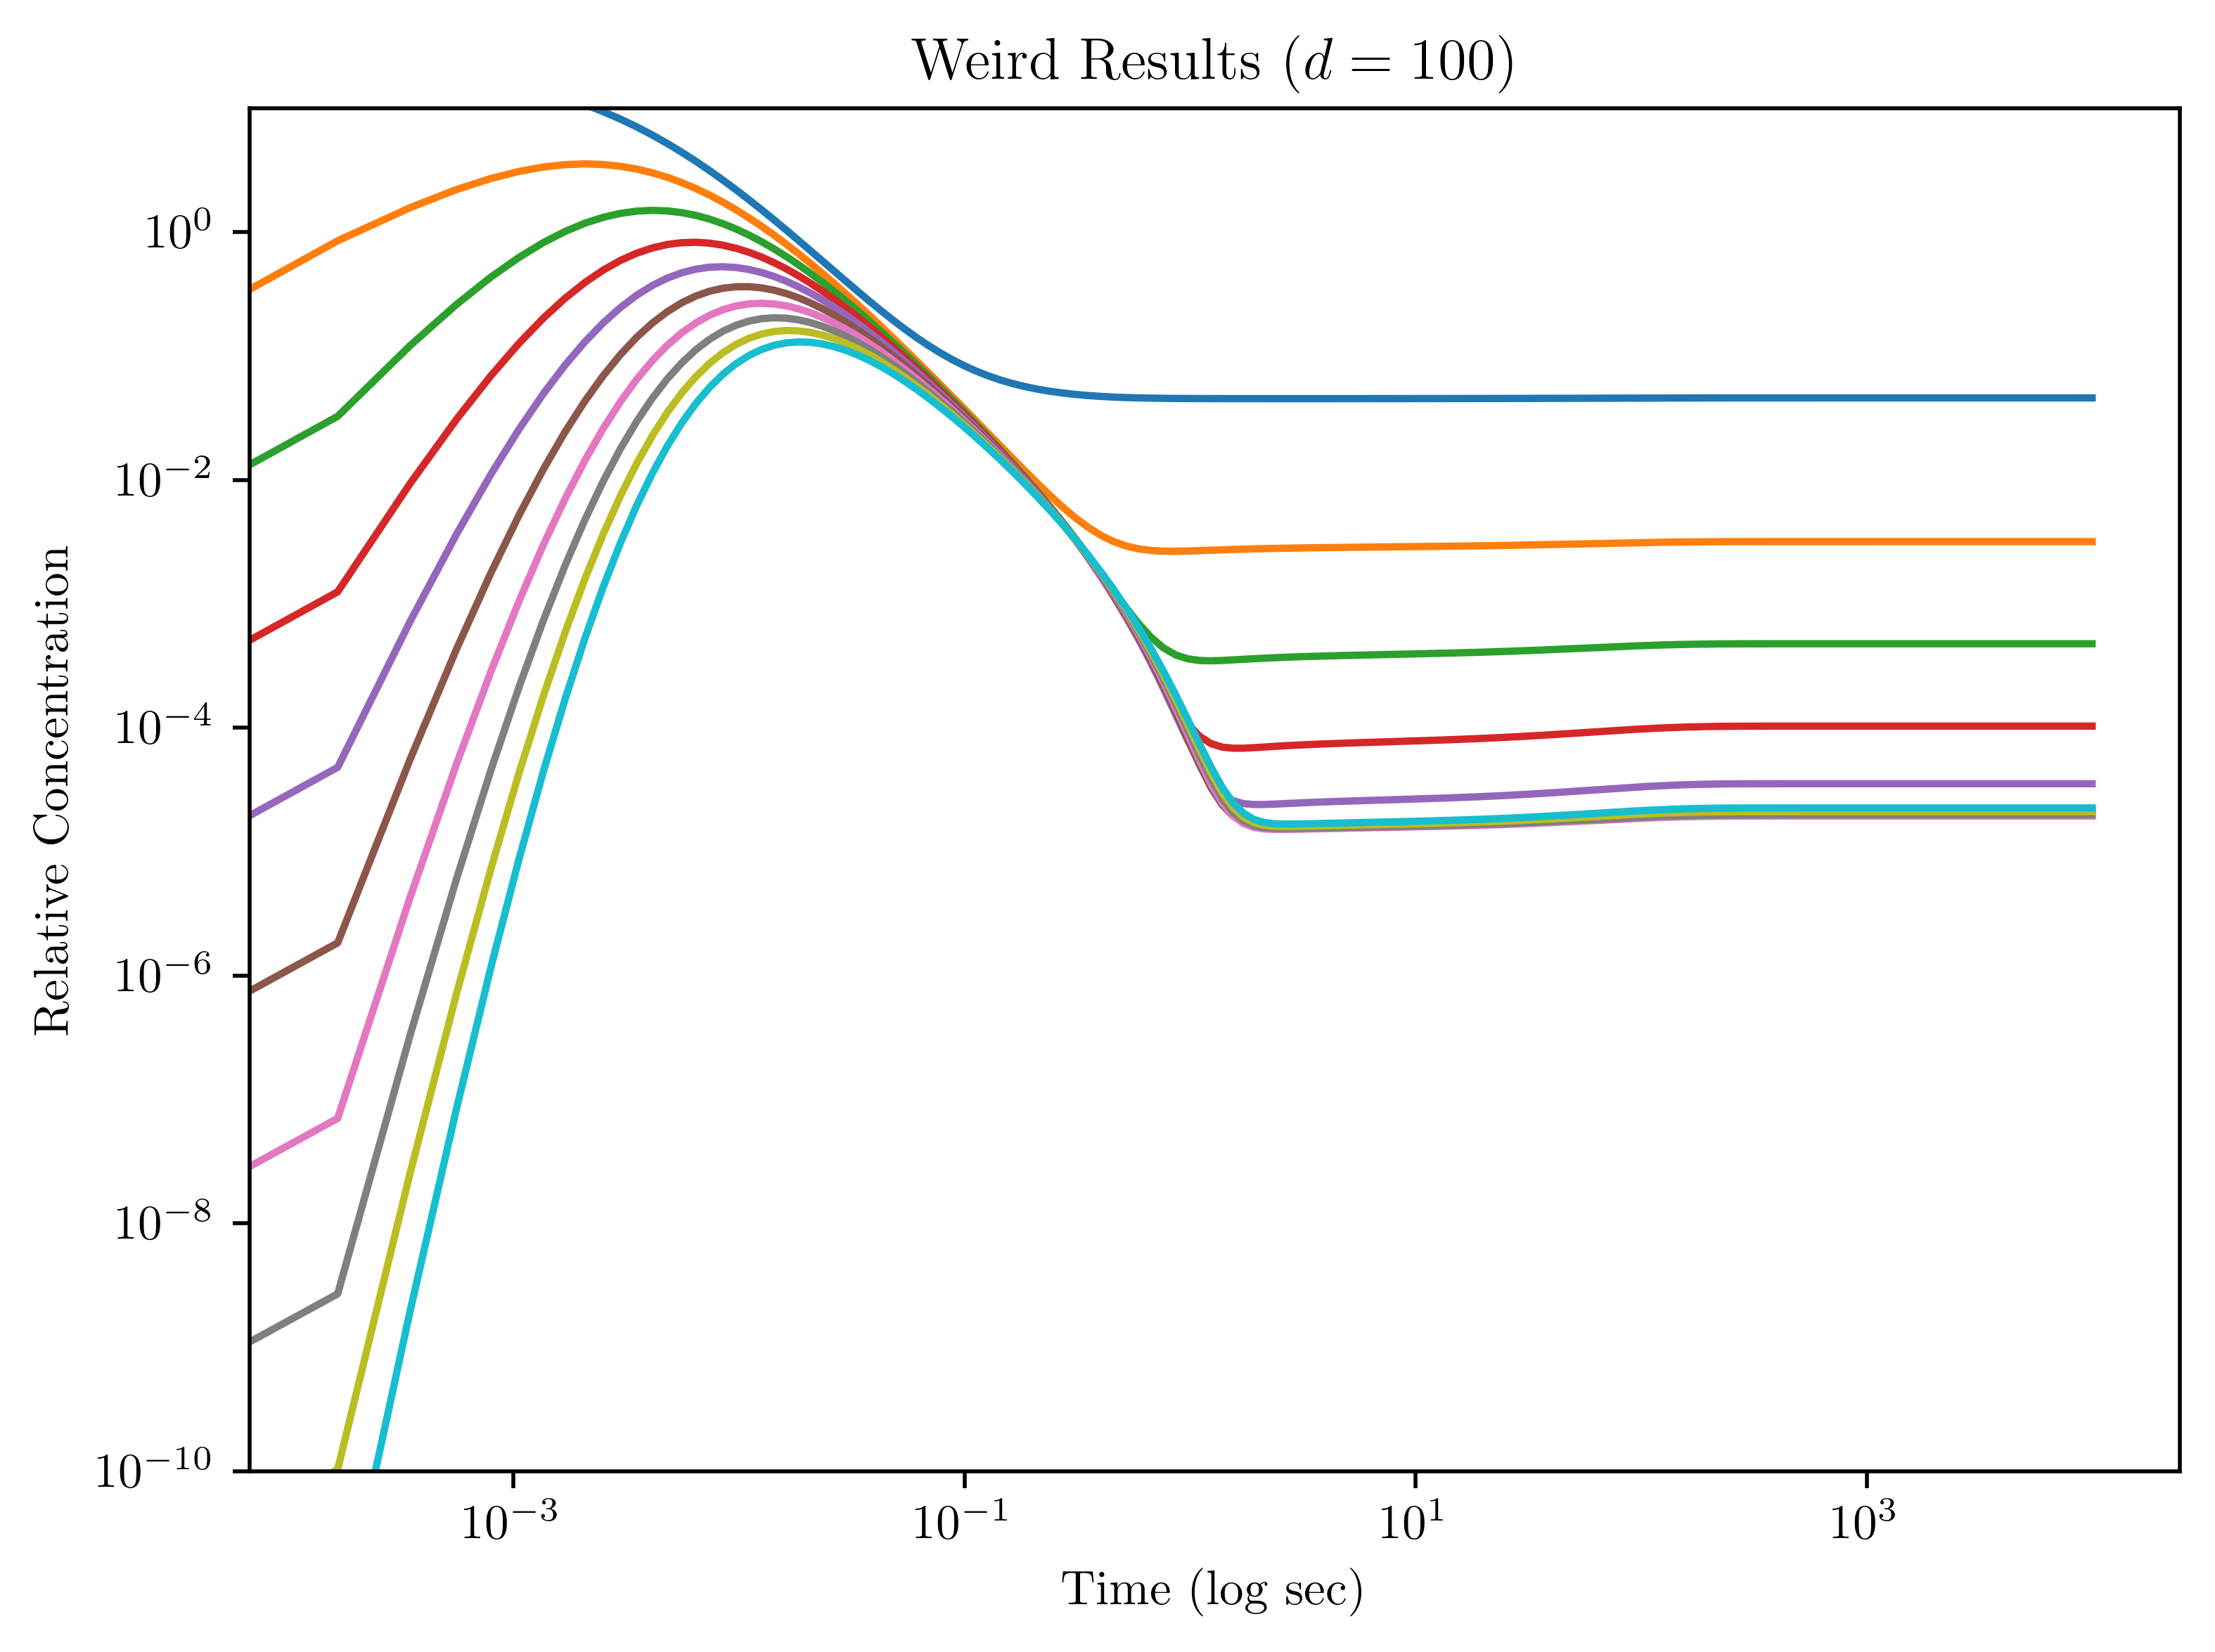

PyObject Text(0.5, 1, 'Weird Results ($d=100$)')

In [40]:
f = Plt.figure()
ax = f.gca()
ax.loglog(d100.t, permutedims(hcat(d100.u...))[:,1:10])
ax.set_ylim(1e-10, 10) 
#ax.set_xlim(1e3, 1e6)
ax.set_xlabel("Time (log sec)")
ax.set_ylabel("Relative Concentration")

ax.set_title(raw"Weird Results ($d=100$)")

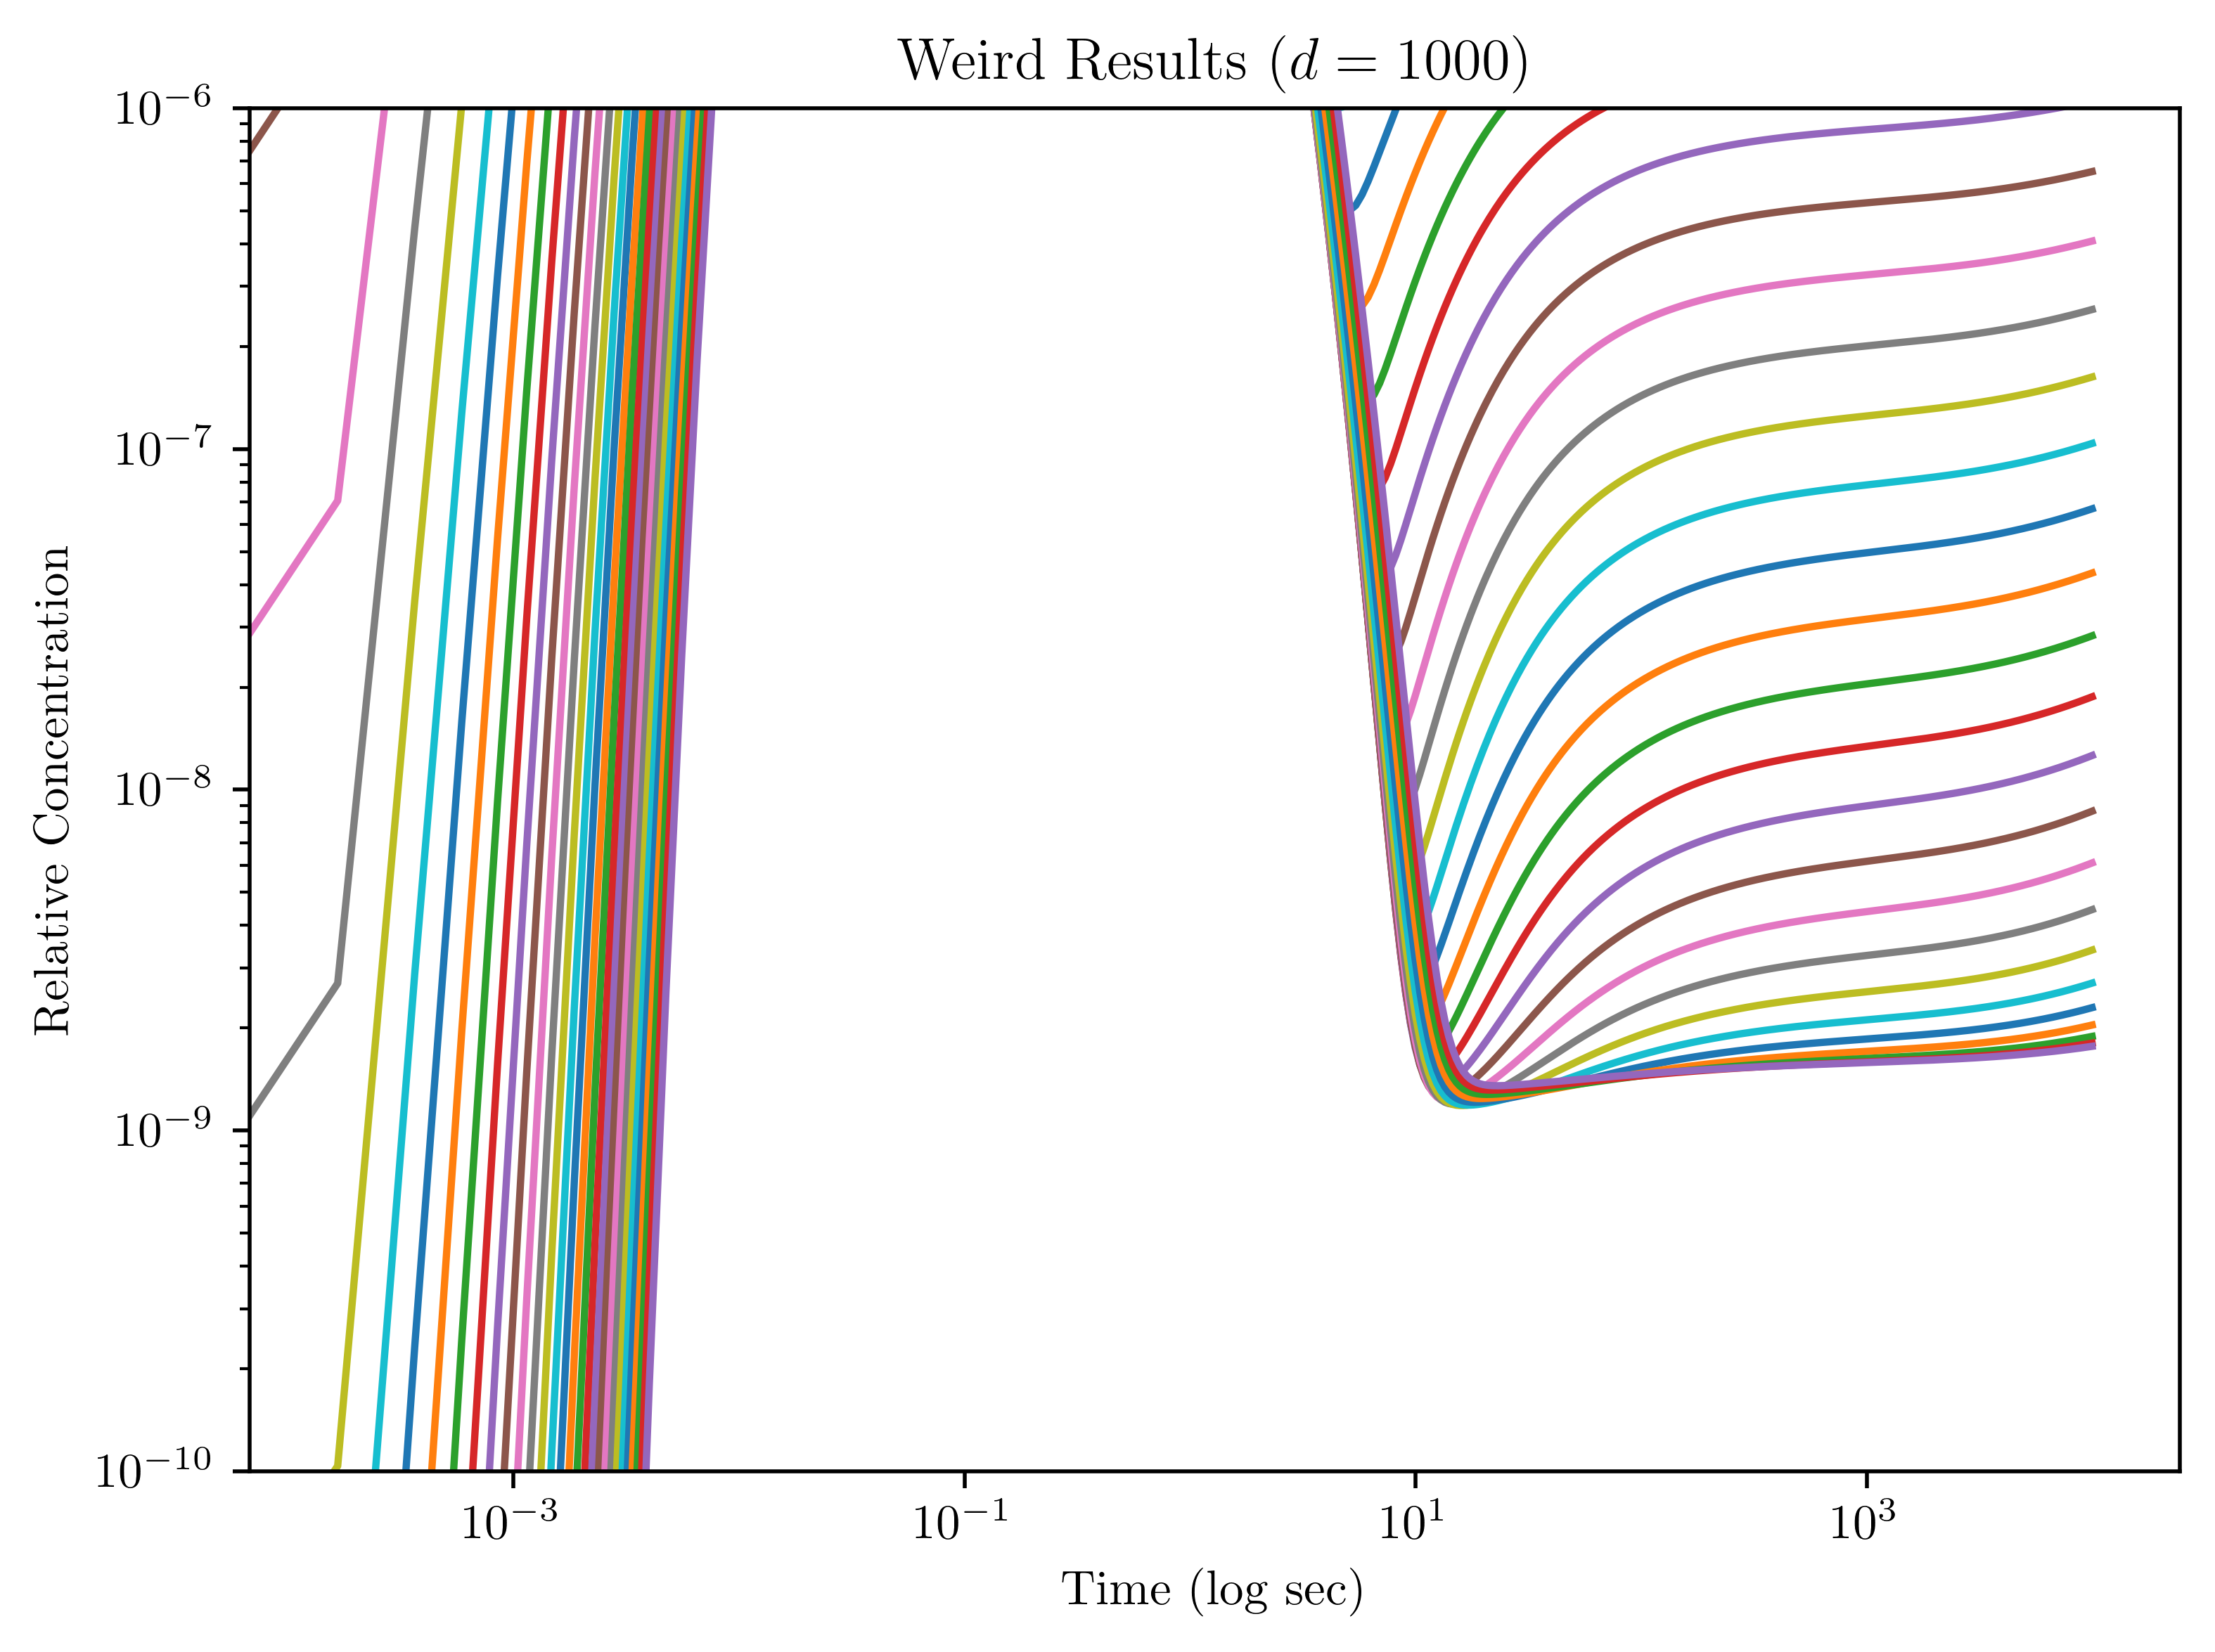

PyObject Text(0.5, 1, 'Weird Results ($d=1000$)')

In [30]:
f = Plt.figure()
ax = f.gca()
ax.loglog(d1000.t, permutedims(hcat(d1000.u...))[:,1:35])
ax.set_ylim(1e-10, 1e-6) 
#ax.set_xlim(1e3, 1e6)
ax.set_xlabel("Time (log sec)")
ax.set_ylabel("Relative Concentration")

ax.set_title(raw"Weird Results ($d=1000$)")

# Polymer Length Distribution

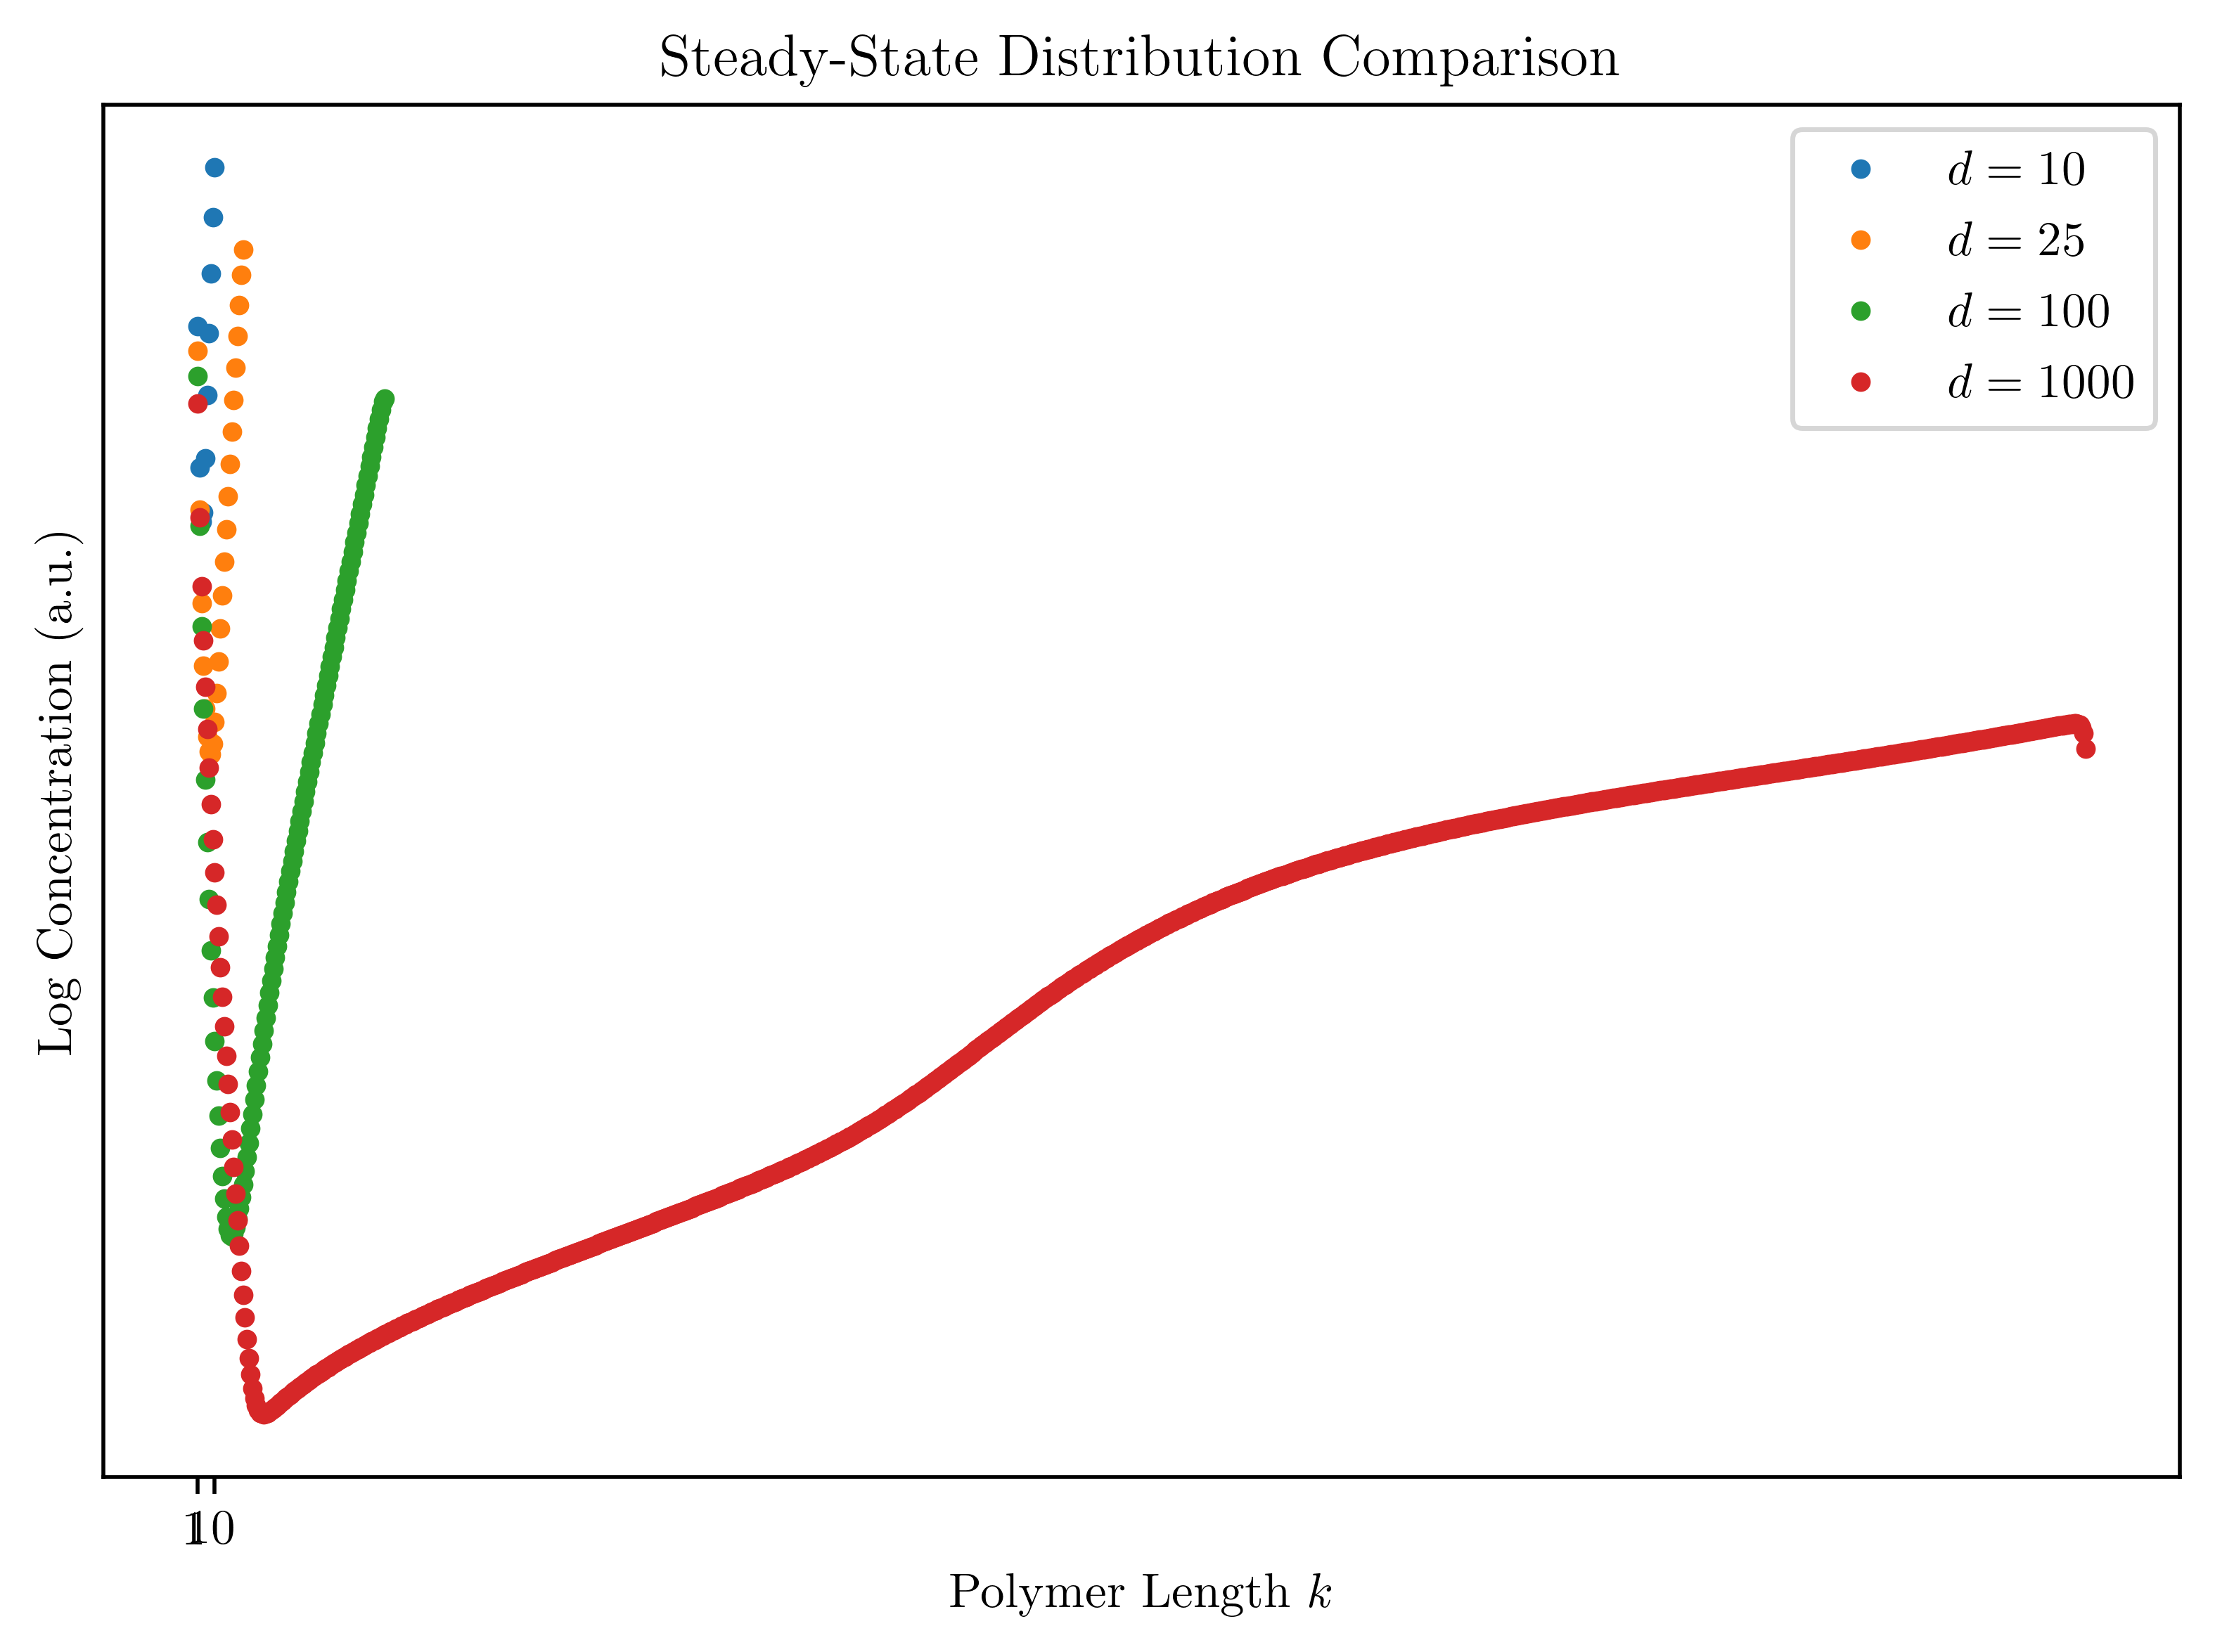

In [33]:
f = Plt.figure()
ax = f.gca()
ax.plot(1:10, log.(d10.u[end]), "."; label=raw"$d=10$")
xlim = ax.get_xlim()
ax.plot(1:25, log.(d25.u[end]), "."; label=raw"$d=25$")
ax.plot(1:100, log.(d100.u[end]), "."; label=raw"$d=100$")
ax.plot(1:1000, log.(d1000.u[end]), "."; label=raw"$d=1000$")
# ax.set_xlim(xlim)
ax.legend(loc=0)
ax.set_xticks([1, 10])
ax.set_yticks([])
ax.set_xlabel(raw"Polymer Length $k$")
ax.set_ylabel(raw"Log Concentration (a.u.)")
ax.set_title("Steady-State Distribution Comparison")
;